# CH06: Learning Best Practices for Model Evaluation and Hyperparameter Tuning

## Streamling workflows with pipelines

### Loading the Breast Cancer Wisconsin dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

In [2]:
data = load_breast_cancer()

df = pd.DataFrame(data["data"], columns=data["feature_names"])
df["target"] = np.array(["M", "B"])[data["target"]]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 non-null float64
symmetry error             569 

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [6]:
le = LabelEncoder().fit(y)
y = le.transform(y)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [8]:
print(pd.value_counts(y_train, normalize=True))
print()
print(pd.value_counts(y_test, normalize=True))

0    0.626374
1    0.373626
dtype: float64

0    0.631579
1    0.368421
dtype: float64


### Combining transformers and estimators in a pipeline

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [10]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(random_state=1))
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [11]:
y_pred = pipe_lr.predict(X_test)

In [12]:
print("Test accuracy: %.3f" % pipe_lr.score(X_test, y_test))

Test accuracy: 0.956


## Using k-fold cross-validation to assess model performacne

In [13]:
from sklearn.model_selection import StratifiedKFold

In [14]:
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X_train, y_train)

In [15]:
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print("Fold: %d, Class dist.: %s, Acc: %.3f" % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.935
Fold: 2, Class dist.: [256 153], Acc: 0.935
Fold: 3, Class dist.: [256 153], Acc: 0.957
Fold: 4, Class dist.: [256 153], Acc: 0.957
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.956
Fold: 7, Class dist.: [257 153], Acc: 0.978
Fold: 8, Class dist.: [257 153], Acc: 0.933
Fold: 9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
scores

array([0.93478261, 0.93478261, 0.95652174, 0.95652174, 0.93478261,
       0.95555556, 0.97777778, 0.93333333, 0.95555556, 0.95555556])

## Debugging algorithms with learning and validation curves

### Diagnosing bias and variance problems with learning curves

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [19]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", random_state=1))
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10, n_jobs=1
)

In [20]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

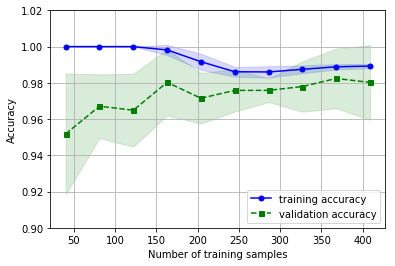

In [21]:
plt.plot(train_sizes, train_mean, color="blue", marker="o", markersize=5, label="training accuracy")
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color="blue")
plt.plot(train_sizes, test_mean, color="green", linestyle="--", marker="s", markersize=5, label="validation accuracy")
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color="green")
plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.9, 1.02])
plt.show()

### Addressing over- and underfitting with validation curves

In [22]:
from sklearn.model_selection import validation_curve

In [23]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr, X=X_train, y=y_train, param_name="logisticregression__C",
    param_range=param_range, cv=10
)

In [24]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

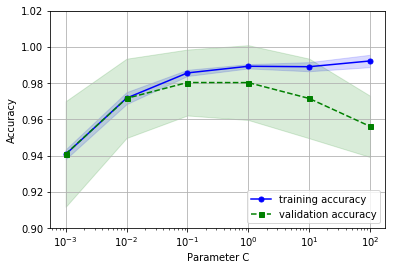

In [25]:
plt.plot(param_range, train_mean, color="blue", marker="o", markersize=5, label="training accuracy")
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color="blue")
plt.plot(param_range, test_mean, color="green", linestyle="--", marker="s", markersize=5, label="validation accuracy")
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color="green")
plt.grid()
plt.xscale("log")
plt.xlabel("Parameter C")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.9, 1.02])
plt.show()

## Fine-tuning machine learning models via grid search

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [27]:
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))

In [28]:
param_range = [ 10**i for i in range(-4, 4,) ]
param_grid = [
    {"svc__C": param_range, "svc__kernel": ["linear"]},
    {"svc__C": param_range, "svc__gamma": param_range, "svc__kernel": ["rbf"]}
]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'svc__kernel': ['linear']}, {'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'svc__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [29]:
print(gs.best_score_)
print(gs.best_params_)

0.9846153846153847
{'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


### Algorithm selection with nested cross-validation

In [30]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring="accuracy", cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)

In [31]:
np.mean(scores)

0.9736263736263737

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=0), 
    param_grid=[{"max_depth": [1, 2, 3, 4, 5, 6, 7, None]}], 
    scoring="accuracy", cv=2
)
scores = cross_val_score(gs, X_train, y_train, scoring="accuracy", cv=5)

In [34]:
np.mean(scores)

0.9340659340659341

## Looking at different performance evaluation metrices

#### Confusion matrix

In [37]:
from sklearn.metrics import confusion_matrix

In [39]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)

In [40]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[71,  1],
       [ 2, 40]])

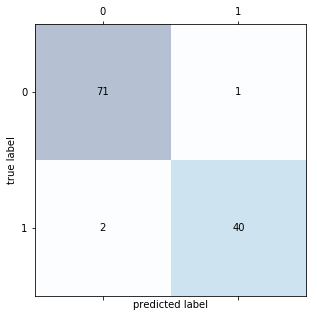

In [46]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va="center", ha="center")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [47]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

In [48]:
precision_score(y_true=y_test, y_pred=y_pred)

0.975609756097561

In [49]:
recall_score(y_true=y_test, y_pred=y_pred)

0.9523809523809523

In [50]:
f1_score(y_true=y_test, y_pred=y_pred)

0.963855421686747

### Receiver Operating Characteristic (ROC)

In [52]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [53]:
pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(penalty="l2", random_state=1, C=100.0))

In [54]:
X_train2 = X_train[:, [4, 14]]

In [55]:
cv = list(StratifiedKFold(n_splits=3, random_state=1).split(X_train, y_train))

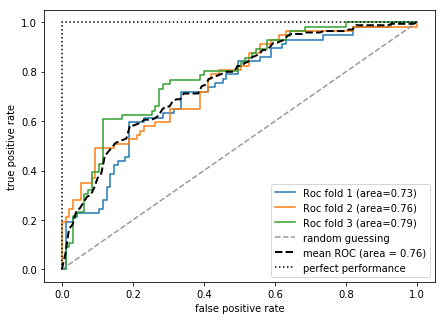

In [65]:
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probs = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probs[:, 1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="Roc fold %d (area=%0.2f)" % (i+1, roc_auc))
    
plt.plot([0, 1], [0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="random guessing")

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="mean ROC (area = %0.2f)" % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="perfect performance")

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="lower right")
plt.show()

## Dealing with class imbalance

In [67]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))